Introduction

While exploring regression, we've briefly mentioned overfitting and the problems it can cause. In this mission, we'll explore how to identify overfitting and what you can do to avoid it. To explore overfitting, we'll use a dataset on cars which dataset contains 7 numerical features that could have an effect on a car's fuel efficiency:

In [1]:
import pandas as pd
columns = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model year", "origin", "car name"]
cars = pd.read_table("auto-mpg.data", delim_whitespace=True, names=columns)
filtered_cars = cars[cars['horsepower'] != '?']
filtered_cars['horsepower'] = filtered_cars['horsepower'].astype('float')

C:\Users\kknagara\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Bias and Variance

At the heart of understanding overfitting is understanding bias and variance. Bias and variance make up the 2 observable sources of error in a model that we can indirectly control.

Bias describes error that results in bad assumptions about the learning algorithm. For example, assuming that only one feature, like a car's weight, relates to a car's fuel efficiency will lead you to fit a simple, univariate regression model that will result in high bias. The error rate will be high since a car's fuel efficiency is affected by many other factors besides just its weight.

Variance describes error that occurs because of the variability of a model's predicted values. If we were given a dataset with 1000 features on each car and used every single feature to train an incredibly complicated multivariate regression model, we will have low bias but high variance.

In an ideal world, we want low bias and low variance but in reality, there's always a tradeoff.

Bias-variance tradeoff

We've discussed before how overfitting generally happens when a model performs well on a training set but doesn't generalize well to new data. A key nuance here is that you should think of overfitting as a relative term. Between any 2 models, one will overfit more than the other one.

Understanding the bias variance tradeoff is critical to understanding overfitting. Every process has some amount of inherent noise that's unobservable. Overfit models tend to capture the noise as well as the signal in a dataset.

Scott Fortman Roe's blog post on the bias-variance tradeoff has a wonderful image that describes this tradeoff:

Imgur

We can approximate the bias of a model by training a few different models from the same class (linear regression in this case) using different features on the same dataset and calculating their error scores. For regression, we can use mean absolute error, mean squared error, or R-squared.

We can calculate the variance of the predicted values for each model we train and we'll observe an increase in variance as we build more complex, multivariate models.

While an extremely simple, univariate linear regression model will underfit, an extremely complicated, multivariate linear regression model will overfit. Depending on the problem you're working on, there's a happy middle ground that will help you construct reliable and useful predictive models.

Let's first create a function that we can use for training the model and computing the bias and variance values and use it to train some simple, univariate models.


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
def train_and_test(cols):
    # Split into features & target.
    features = filtered_cars[cols]
    target = filtered_cars["mpg"]
    # Fit model.
    lr = LinearRegression()
    lr.fit(features, target)
    # Make predictions on training set.
    predictions = lr.predict(features)
    # Compute MSE and Variance.
    mse = mean_squared_error(filtered_cars["mpg"], predictions)
    variance = np.var(predictions)
    return(mse, variance)
cyl_mse, cyl_var = train_and_test(["cylinders"])
weight_mse, weight_var = train_and_test(["weight"])

Multivariate models

Now that we have a function for training a regression model and calculating the mean squared error and variance, let's use it to train and understand more complex models

In [3]:
# Our implementation for train_and_test, takes in a list of strings.
def train_and_test(cols):
    # Split into features & target.
    features = filtered_cars[cols]
    target = filtered_cars["mpg"]
    # Fit model.
    lr = LinearRegression()
    lr.fit(features, target)
    # Make predictions on training set.
    predictions = lr.predict(features)
    # Compute MSE and Variance.
    mse = mean_squared_error(filtered_cars["mpg"], predictions)
    variance = np.var(predictions)
    return(mse, variance)

one_mse, one_var = train_and_test(["cylinders"])
two_mse, two_var = train_and_test(["cylinders", "displacement"])
three_mse, three_var = train_and_test(["cylinders", "displacement", "horsepower"])
four_mse, four_var = train_and_test(["cylinders", "displacement", "horsepower", "weight"])
five_mse, five_var = train_and_test(["cylinders", "displacement", "horsepower", "weight", "acceleration"])
six_mse, six_var = train_and_test(["cylinders", "displacement", "horsepower", "weight", "acceleration", "model year"])
seven_mse, seven_var = train_and_test(["cylinders", "displacement", "horsepower", "weight", "acceleration","model year", "origin"])

Cross validation

The multivariate regression models you trained got progressively better at reducing the amount of error.

A good way to detect if your model is overfitting is to compare the in-sample error and the out-of-sample error, or the training error with the test error. So far, we calculated the in sample error by testing the model over the same data it was trained on. To calculate the out-of-sample error, we need to test the data on a test set of data. We unfortunately don't have a separate test dataset and we'll instead use cross validation.

If a model's cross validation error (out-of-sample error) is much higher than the in sample error, then your data science senses should start to tingle. This is the first line of defense against overfitting and is a clear indicator that the trained model doesn't generalize well outside of the training set.

Let's create a new function to handle performing the cross validation and computing the cross validation error.

In [4]:
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
def train_and_cross_val(cols):
    features = filtered_cars[cols]
    target = filtered_cars["mpg"]
    
    variance_values = []
    mse_values = []
    
    # KFold instance.
    kf = KFold(n=len(filtered_cars), n_folds=10, shuffle=True, random_state=3)
        # Iterate through over each fold.
    for train_index, test_index in kf:
        # Training and test sets.
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # Fit the model and make predictions.
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        predictions = lr.predict(X_test)
        # Calculate mse and variance values for this fold.
        mse = mean_squared_error(y_test, predictions)
        var = np.var(predictions)

        # Append to arrays to do calculate overall average mse and variance values.
        variance_values.append(var)
        mse_values.append(mse)
    # Compute average mse and variance values.
    avg_mse = np.mean(mse_values)
    avg_var = np.mean(variance_values)
    return(avg_mse, avg_var)        
        
two_mse, two_var = train_and_cross_val(["cylinders", "displacement"])
three_mse, three_var = train_and_cross_val(["cylinders", "displacement", "horsepower"])
four_mse, four_var = train_and_cross_val(["cylinders", "displacement", "horsepower", "weight"])
five_mse, five_var = train_and_cross_val(["cylinders", "displacement", "horsepower", "weight", "acceleration"])
six_mse, six_var = train_and_cross_val(["cylinders", "displacement", "horsepower", "weight", "acceleration", "model year"])
seven_mse, seven_var = train_and_cross_val(["cylinders", "displacement", "horsepower", "weight", "acceleration","model year", "origin"])        

Plotting cross-validation error vs. cross-validation variance

During cross validation, the more features we added to the model, the lower the mean squared error got. This is a good sign and indicates that the model generalizes well to new data it wasn't trained on. As the mean squared error value went down, however, the variance of the predictions went up. This is to be expected, since the models with lower squared error values had higher model complexity, which tends to be more sensitive to small variations in input values (or high variance).

For each model, let's plot the error and variance to get a better idea of the tradeoff as the number of features increased.

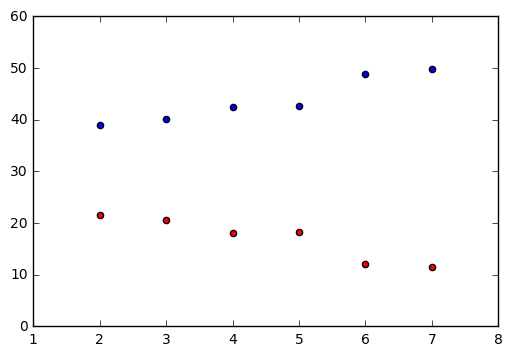

In [5]:
import matplotlib.pyplot as plt
plt.scatter([2,3,4,5,6,7], [two_mse, three_mse, four_mse, five_mse, six_mse, seven_mse], c='red')
plt.scatter([2,3,4,5,6,7], [two_var, three_var, four_var, five_var, six_var, seven_var], c='blue')
plt.show()

Conclusion

While the higher order multivariate models overfit in relation to the lower order multivariate models, the in-sample error and out-of-sample didn't deviate by much. The best model was around 50% more accurate than the simplest model. On the other hand, the overall variance increased around 25% as we increased the model complexity. This is a really good starting point, but your work is not done! The increased variance with the increased model complexity means that your model will have more unpredictable performance on truly new, unseen data.

If you were working on this problem on a data science team, you'd need to confirm the predictive accuracy of the model using completely new, unobserved data (e.g. maybe from cars from later years). Since often you can't wait until a model is deployed in the wild to know how well it works, the exploration we did in this mission helps you approximate a model's real world performance.